In [20]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import os
from datetime import datetime, timedelta
from torch_geometric.utils import from_scipy_sparse_matrix

In [2]:
train_len = 36481
valid_len = 7817
window_len = 12 + 12 # 12 for history | 12 for future

start_ts = datetime.strptime('20170101T00:00:00', '%Y%m%dT%H:%M:%S')
timestamps = [start_ts + timedelta(minutes = 5 * train_len) + timedelta(minutes = 5 * i) for i in range(valid_len - window_len)]

num_cloudlets = 7

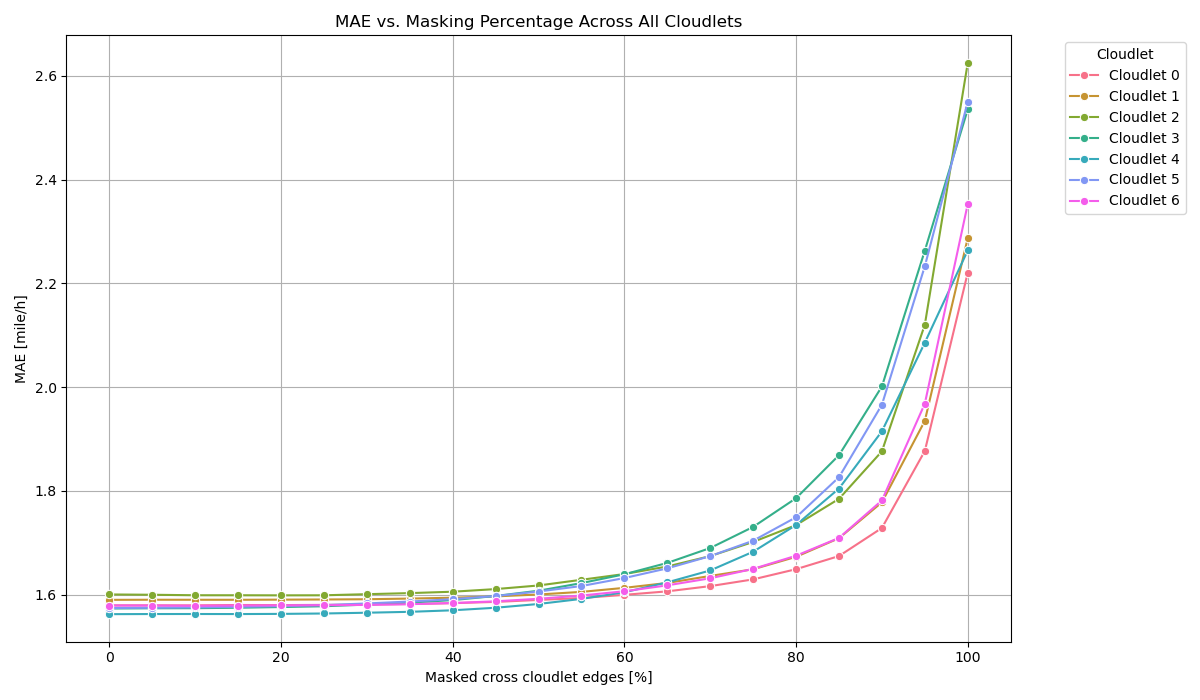

In [27]:
data_folder = "../logs/2025-04-11_09-40-50_pems-bay_pred-15min_his-60min_ray-semi-dec-server-free-fl-distance_online-training/"

# Create a color palette for the cloudlets
colors = sns.color_palette("husl", num_cloudlets)

plt.figure(figsize=(12, 7))

for cloudlet_num in range(num_cloudlets):
    cloudlet_path = os.path.join(data_folder, str(cloudlet_num))
    csv_files = [f for f in os.listdir(cloudlet_path) 
                 if f.endswith('.csv') and f.startswith(f'cloudlet_{cloudlet_num}_')]
    
    # Prepare data for this cloudlet
    percentages = []
    mae_values = []
    
    for csv_file in sorted(csv_files):
        # Extract the percentage from the filename
        if "original" in csv_file:
            percentage = 0.0
        else:
            percentage = float(csv_file.split('_')[-1].replace('-percent-masked.csv', ''))
        
        # Load the CSV file
        file_path = os.path.join(cloudlet_path, csv_file)
        df = pd.read_csv(file_path)
        
        percentages.append(percentage)
        mae_values.append(df['MAE'].values[0])
    
    # Convert to numpy arrays and sort
    percentages = np.array(percentages)
    mae_values = np.array(mae_values)
    sort_idx = np.argsort(percentages)
    percentages = percentages[sort_idx]
    mae_values = mae_values[sort_idx]
    
    # Plot this cloudlet's data
    sns.lineplot(x=percentages, y=mae_values, marker='o', 
                 label=f'Cloudlet {cloudlet_num}', color=colors[cloudlet_num])
    
# Customize the plot
plt.title('MAE vs. Masking Percentage Across All Cloudlets')
plt.xlabel('Masked cross cloudlet edges [%]')
plt.ylabel('MAE [mile/h]')
plt.grid(True)
plt.legend(title='Cloudlet', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format x-axis as percentages
# plt.gca().set_xticks(np.arange(0, 1.05, 0.05))
# plt.gca().set_xticklabels([f'{int(x*100)}%' for x in np.arange(0, 1.05, 0.05)])

plt.tight_layout()
plt.show()

# cloudlet_path = os.path.join(data_folder, str(0))
# csv_files = [f for f in os.listdir(cloudlet_path) if f.endswith('.csv') and f.startswith(f'cloudlet_{0}_')]
# csv_files

In [21]:
dataset_name = "pems-bay"
adj_file_name = "adj.npz"

dataset_path = '../data'
dataset_path = os.path.join(dataset_path, dataset_name)
adj = sp.load_npz(os.path.join(dataset_path, adj_file_name)) # dimensions: (207, 207)
adj = adj.tocsc() # convert adj from compressed sparse row (CSR) to compressed sparse column format (CSC)

edge_index, edge_weight = from_scipy_sparse_matrix(adj)
print(f"{edge_weight}")
print(f"{len(edge_weight)}")

tensor([1.0000, 0.9817, 0.1059,  ..., 0.8129, 0.9001, 1.0000],
       dtype=torch.float64)
38887


In [22]:
logs_folder = "../logs/2025-04-11_09-40-50_pems-bay_pred-15min_his-60min_ray-semi-dec-server-free-fl-distance_online-training/"
edge_counts_df = pd.read_csv(os.path.join(logs_folder, "edge_counts", "cloudlet_0.csv"))
edge_scores_df = pd.read_csv(os.path.join(logs_folder, "edge_scores", "cloudlet_0.csv"))

edge_ids = edge_counts_df.columns.astype(int).values
count_values = edge_counts_df.iloc[0].values
score_values = edge_scores_df.iloc[0].values

edge_id_to_weight = {edge_id: edge_weight[i].item() for i, edge_id in enumerate(edge_ids)}

# Prepare data for plotting
plot_data = pd.DataFrame({
    'edge_id': edge_ids,
    'edge_weight': [edge_id_to_weight[eid] for eid in edge_ids],
    'edge_count': count_values,
    'edge_score': score_values
})
plot_data['edge_ratio'] = plot_data['edge_score'] / plot_data['edge_count']

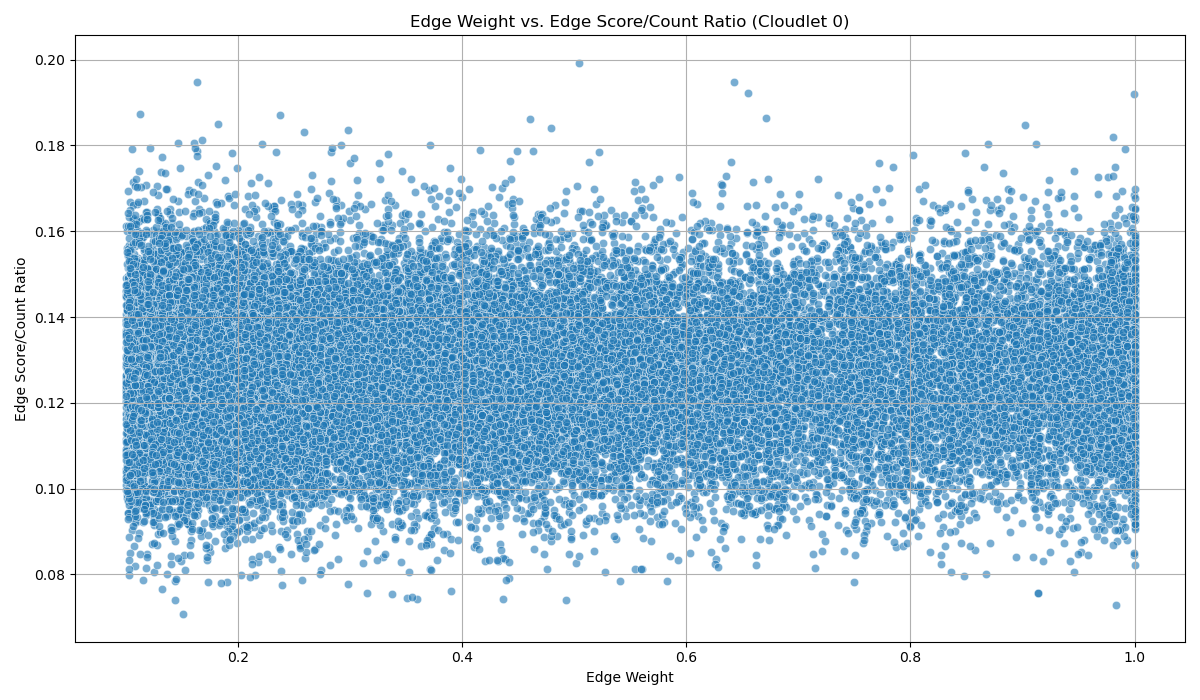

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 7))

sns.scatterplot(data=plot_data, x='edge_weight', y='edge_ratio', ax=ax1, alpha=0.6)
ax1.set_title('Edge Weight vs. Edge Score/Count Ratio (Cloudlet 0)')
ax1.set_xlabel('Edge Weight')
ax1.set_ylabel('Edge Score/Count Ratio')
ax1.grid(True)

plt.tight_layout()
plt.show()